In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})
import trimesh as tr
import pyrender as pr
import colorcet as cc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

intrinsics
[[    511.00       0.00     320.00]
 [      0.00     511.00     256.00]
 [      0.00       0.00       1.00]]
pinhole projection matrix
[[    -75.61     -80.22      43.70     412.71]
 [      1.66      21.25     110.42     235.58]
 [      0.06      -0.14       0.11       1.00]]



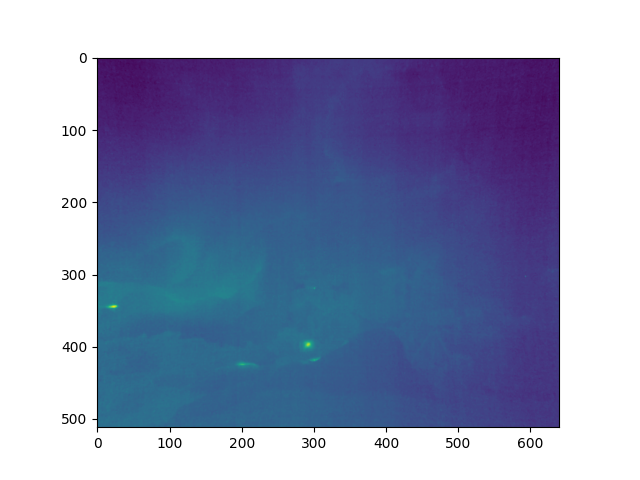

In [13]:
from src.pyushichka import loadCalibration, loadImageUndistorted
ushichka_dir = "/home/julian/data/ushichka/2018-08-17/"
cam = 1 # 2nd camera
imK, imP = loadCalibration(cam, ushichka_dir)
imIm = loadImageUndistorted(cam, 0, ushichka_dir)

print(f"intrinsics\n{imK}\npinhole projection matrix\n{imP}\n")
plt.figure()
plt.imshow(imIm)
plt.show()

from src.dmcpworkflow.capture_depth import generate_depth_map
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
ovMesh = pr.Mesh.from_trimesh(tr.load_mesh(mesh_path))
pvMesh = pv.read(mesh_path)

# DMCP Workflow

## Generate Depth Map

In [14]:
print("generating depth map")
view_width = 1920
view_height = 1080

view_K = imK.copy()
view_K[0,-1] = view_width /2
view_K[1,-1] = view_width / 2

dmimIm, dmIm, dmK, dmP = generate_depth_map(ovMesh,view_K,znear=0.00001,zfar=100,return_img=True)

generating depth map
[[      0.64       0.50      -0.58       1.60]
 [      0.75      -0.26       0.61      -1.26]
 [      0.15      -0.83      -0.54      -0.49]]
[[      0.64      -0.50       0.58]
 [      0.75       0.26      -0.61]
 [      0.15       0.83       0.54]]
[[      1.60]
 [     -1.26]
 [     -0.49]]


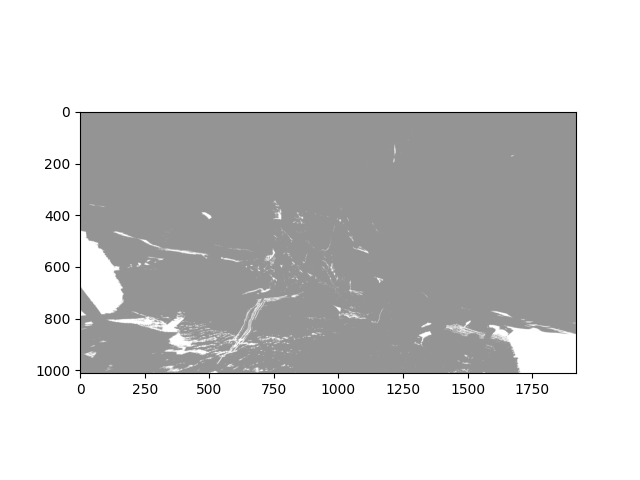

<class 'numpy.ndarray'>


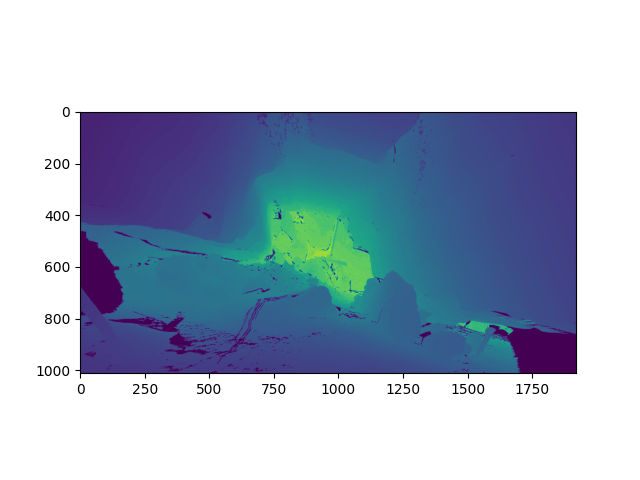

In [15]:
plt.figure()
plt.imshow(dmimIm)
plt.show()

print(type(dmIm))

plt.figure()
plt.imshow(dmIm)
plt.show()

## Annotate Points

In [16]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("TKAgg")
cps = annotate(imIm, dmIm)
%matplotlib inline

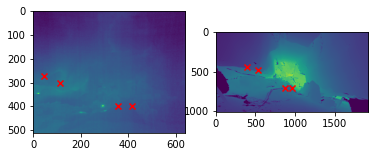

In [17]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r",marker="x")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r",marker="x")
plt.show()

## project to world

In [18]:
from src.pycv.dmcp import dm_to_world

pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
pts_world

array([[     -1.30,       1.36,      -0.99],
       [     -1.86,       1.03,      -1.04],
       [     -2.05,      -1.18,      -0.23],
       [     -2.85,      -0.63,      -0.16]], dtype=float32)

In [19]:
# visualize cps in world coordinates

pvPts = pv.PolyData(pts_world)

pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)

pl.show()

## dmcp step

In [20]:
from src.pycv.dmcp import dmcp

raw_pose, trans = dmcp(imK, imP, cps[:,:2], pts_world,return_raw_pose=True)
print(f"transformation\n{trans}")

estimated pose
[[      0.50      -0.32      -0.81       1.73]
 [      0.87       0.19       0.46      -1.18]
 [      0.01      -0.93       0.37      -1.40]]
scale factor 0.19646079031611327
transformation
[[     -0.65       0.55      -0.53      13.86]
 [     -0.65      -0.03       0.76      -3.40]
 [      0.40       0.84       0.37      -1.84]
 [      0.00       0.00       0.00       1.00]]


In [21]:
print("estiated position")
P_est = imP @ la.inv(trans)
pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]

position_est = pose_est[:3].flatten()
print(position_est)

estiated position
[     18.28      -5.27       0.34]


ESTIMATED POSE SEEMS TO BE CORRECT BUT TRANSFORMATIOON FAILES

==> Scaling?!?

In [22]:
sv_pos_raw = pv.Sphere(radius=0.25, center=raw_pose[:3,-1])
sv_pos_est = pv.Sphere(radius=0.25, center=position_est)
pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)
pl.add_mesh(sv_pos_est, color="yellowgreen")
pl.add_mesh(sv_pos_raw, color="green")

pl.show()